In [1]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_squared_error
from pandas import Series
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings('ignore')

## Load Data

In [2]:
USDC=pd.read_csv('USDC Price.csv')
USDC['Date'] = pd.to_datetime(USDC['Date'])

In [3]:
USDC_train = USDC[USDC.Date <= '2020-12-31']
USDC_test =  USDC[USDC.Date >= '2021-01-01']

In [4]:
USDC

,Date,USDC Price
0,2018-10-08,1.002210
1,2018-10-09,1.006860
2,2018-10-10,1.009620
3,2018-10-11,1.009780
4,2018-10-12,1.012720
...,...,...
919,2021-04-14,0.999534
920,2021-04-15,0.999178
921,2021-04-16,0.999518
922,2021-04-17,0.999383


## Define Performance Criteria: Mean Absolutee Percentage Error

In [5]:
def get_mape(actuals, forecasts):
    MAPE = np.sum(abs(forecasts-actuals)/actuals)/len(actuals)
    return MAPE

## Hyperparameter Selection

In [6]:
p_values = range(0, 5)
d_values = range(0, 3)                   
q_values = range(0, 3)                   

In [7]:
def evaluate_model(train, test, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values: 
            for q in q_values:
                order= (p,d,q)
                try:
                    model_arima = ARIMA(train, order=order)
                    model_arima_fit = model_arima.fit()
                    arima_pred = model_arima_fit.forecast(108)
                    mape=get_mape(test, arima_pred[0])
                    print("order: ", order, "mape: ", mape)
                    if mape < best_score:
                        best_score, best_cfg = mape, order
                except:
                    continue
    print('Best ARIMA and MAPE ',best_cfg, best_score)

In [8]:
evaluate_model(USDC_train['USDC Price'], USDC_test['USDC Price'], p_values, d_values, q_values)

order:  (0, 0, 0) mape:  0.0036424820816249315
order:  (0, 0, 1) mape:  0.0036289918508292224
order:  (0, 0, 2) mape:  0.003607453374838369
order:  (0, 1, 0) mape:  0.0010944310191765326
order:  (0, 1, 1) mape:  0.0012561244626308641
order:  (0, 1, 2) mape:  0.001337501314335494
order:  (0, 2, 0) mape:  0.005264650559187268
order:  (0, 2, 1) mape:  0.0009364238228039881
order:  (0, 2, 2) mape:  0.0016135718421981156
order:  (1, 0, 0) mape:  0.0034612716106635693
order:  (1, 0, 1) mape:  0.0027174061703600224
order:  (1, 0, 2) mape:  0.002568220971649212
order:  (1, 1, 0) mape:  0.0011743514975677892
order:  (1, 1, 1) mape:  0.0013624519368015022
order:  (1, 1, 2) mape:  0.0013184529668287908
order:  (1, 2, 0) mape:  0.0371792377892805
order:  (2, 0, 0) mape:  0.0032731157657648617
order:  (2, 0, 1) mape:  0.002571384749176428
order:  (2, 0, 2) mape:  0.002620753332664394
order:  (2, 1, 0) mape:  0.0011067845870906786
order:  (2, 1, 1) mape:  0.0013091118806105224
order:  (2, 1, 2) mape

## Finalizd Model with Best Parameters

In [9]:
# Define model
model_arima = ARIMA(USDC_train['USDC Price'], order=(3,2,1))

# Fit model
start=time.time()
model_arima_fit = model_arima.fit()
end=time.time()
print("time to fit model on training set: ", end-start)

# Create forecasts
begin=time.time()
arima_pred = model_arima_fit.forecast(108)
over=time.time()
print("time to create 2021 forecast: ", over-begin)

time to fit model on training set:  0.6528751850128174
time to create 2021 forecast:  0.0017871856689453125


In [10]:
Price=np.concatenate([np.asarray(USDC_train['USDC Price']),arima_pred[0]])
Date=USDC["Date"]

df=pd.DataFrame(Price).set_index(Date)
df.columns=['Price']

USDC_train = USDC_train.set_index('Date')
USDC = USDC.set_index('Date')

## Plot the Figure

Text(0.5, 1.0, 'Predicted USDC Price')

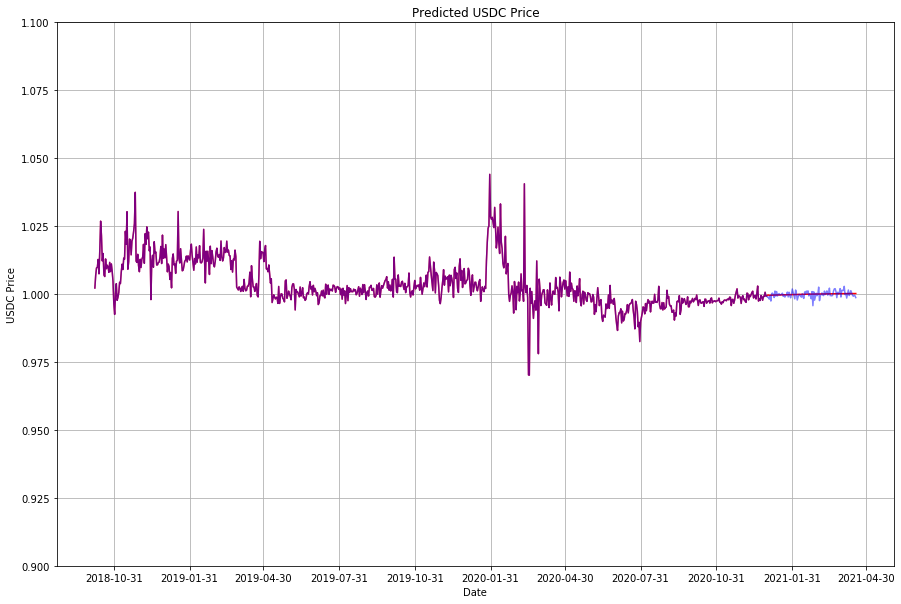

In [11]:
# Plot forecast, test set, and training set
plt.figure(figsize=(15, 10))

plt.plot(df['Price'], c = 'r')
plt.plot(USDC['USDC Price'], c = 'b', alpha=0.5)
plt.ylim([0.9, 1.1])

plt.xticks(pd.date_range('2018-10','2021-7',freq='3m')) 
plt.xlabel("Date")
plt.ylabel("USDC Price")
plt.grid()
plt.title("Predicted USDC Price")

In [12]:
model_arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:          D2.USDC Price   No. Observations:                  814
Model:                 ARIMA(3, 2, 1)   Log Likelihood                3223.793
Method:                       css-mle   S.D. of innovations              0.005
Date:                Wed, 05 May 2021   AIC                          -6435.586
Time:                        00:26:25   BIC                          -6407.374
Sample:                             2   HQIC                         -6424.757
                                                                              
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -8.185e-08   1.09e-06     -0.075      0.940   -2.22e-06    2.06e-06
ar.L1.D2.USDC Price    -0.4709      0.035    -13.418      0.000      -0.540      -0.402
ar.L2.D2.USDC Price    -0.3407      0.038     -9.065      0.000      -0.414      -0.267
ar.L3.D2.USDC Price    -0.1277      0.035     -3.656      0.000      -0.196      -0.059
ma.L1.D2.USDC Price    -0.9886      0.025    -39.621      0.000      -1.037      -0.940
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.1028           -1.7803j            1.7833           -0.2592
AR.2           -0.1028           +1.7803j            1.7833            0.2592
AR.3           -2.4617           -0.0000j            2.4617           -0.5000
MA.1            1.0116           +0.0000j            1.0116            0.0000
-----------------------------------------------------------------------------
"""

In [13]:
arima_mape= get_mape(USDC_test['USDC Price'], arima_pred[0])
print('USDC ARIMA MAPE: ', arima_mape)

USDC ARIMA MAPE:  0.0008707216983311843
